# Rapidly-exploring Random Tree (RRT)

RRT is simple and fast.  It will almost certainly *not* find the best path, but for problems where it's hard to see if there even is a path at all, RRT is great for searching for it.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import random
from math import atan2,sqrt,sin,cos

Define a start point, a goal point, and some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

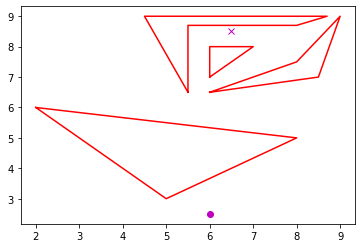

In [2]:
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]]),np.array([[6,7],[7,8],[6,8]]),np.array([[5.5,6.5],[5.5,8.7],[8,8.7],[8.7,9],[4.5,9]])]
#obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]])]

start = [6.,2.5,np.pi/4.]
goal = [6.5,8.5]

def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)

for ob in obstacles:
    plot_poly(ob,'r-')

plt.plot(start[0],start[1],'mo',goal[0],goal[1],'mx')
plt.show()

RRT just needs a list of points, each with an identified 'parent' point, implying a tree structure.

> To get the thing started OK, I put the start point in twice, just so numpy has a 2D array, and define the parent of the root to be -9999, clearly a nonsense node index.

RRT can include a full dynamics model, but here I'm approximating one with a simple constraint: each node moves 0.2 units forward, and cannot change heading more than 0.2 rads.

In [3]:
tree = np.array([start])
parents = np.array([-9999])
tree = np.append(tree,[start],0)
parents = np.append(parents,[-9999])

delta = 0.2
del_hdg = 0.2
print(tree)

[[6.         2.5        0.78539816]
 [6.         2.5        0.78539816]]


Now for the main algorithm:
1. Choose a random point
1. Find the node `nn` (nearest neighbour) on the tree that is closest, here just using the Euclidean distance
1. Extend the tree from `nn` towards the random point, limiting the heading change, creating a new point `newp`
1. Add the new point `newp` to the tree and record that its parent is `nn`

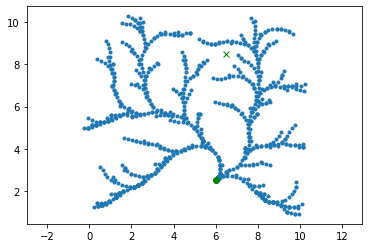

In [4]:
for ii in range(1000):
    r = 10.0*np.array([random(),random()])
    #print(r)
    dx = tree[:,0]-r[0]
    dxx = dx**2
    dy = tree[:,1]-r[1]
    dyy = dy**2
    dsq = dxx+dyy
    #print(dsq)
    nn = np.argmin(dsq)
    #print(nn)
    #print(tree[nn,0],tree[nn,1])
    hdg = atan2(r[0]-tree[nn,0],r[1]-tree[nn,1])
    #print(hdg*180/np.pi)
    if hdg<tree[nn,2]-del_hdg:
        hdg=tree[nn,2]-del_hdg
    elif hdg>tree[nn,2]+del_hdg:
        hdg=tree[nn,2]+del_hdg
    newp = np.array([tree[nn,0]+delta*sin(hdg),tree[nn,1]+delta*cos(hdg),hdg])
    tree = np.append(tree,[newp],0)
    parents = np.append(parents,nn)

plt.plot(tree[:,0],tree[:,1],'.')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.axis('equal')
plt.show()

So far so good: we can grow a nice looking tree.  Time to put the obstacles in, and that requires the visibility checking utilities we developed earlier for the visibility-graph planner.

> Note that angle wrap-around is limiting its direction: room to be cleverer here.

In [5]:
def lines_cross(a,b,c,d):
    M = np.array([[b[0]-a[0],c[0]-d[0]],[b[1]-a[1],c[1]-d[1]]])
    if np.linalg.det(M)==0.:
        return(False)
    v = np.array([[c[0]-a[0]],[c[1]-a[1]]])
    w = np.linalg.solve(M,v)
    if w[0]<=0:
        return(False)
    elif w[0]>=1:
        return(False)
    elif w[1]<=0:
        return(False)
    elif w[1]>=1:
        return(False)
    else:
        return(True)
    
def line_crosses_obst(a,b,obst):
    for ii in range(len(obst)):
        if lines_cross(a,b,obst[ii-1],obst[ii]):
            return(True)
    # extra test in case line is completely inside
    num_crosses = 0
    for ii in range(len(obst)):
        if lines_cross(0.5*(a+b),[max(obst[:,0])+0.01,max(obst[:,1])+0.01],obst[ii-1],obst[ii]):
            num_crosses = num_crosses+1
    if num_crosses%2==1:
        return(True)
    return(False)
            
def is_visible(a,b,obstacles):
    for ob in obstacles:
        if line_crosses_obst(a,b,ob):
            return(False)
    return(True)

Start a fresh tree for the obstacle-avoiding tree.

In [49]:
tree = np.array([start])
parents = np.array([-9999])
tree = np.append(tree,[start],0)
parents = np.append(parents,[-9999])

And here's the algorithm again, this time with the simple addition: if the new branch (twig?) would cut through an obstacle, don't bother adding it to the tree.

> This cell adds (or tries to add) 1,000 nodes to the tree each time you run it.  Repeat running it to see the effect of longer runs.

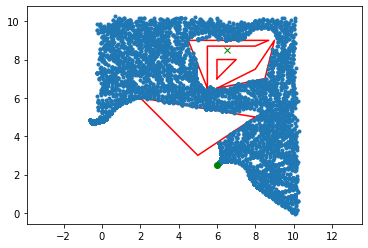

In [61]:
for ii in range(1000):
    r = 10.0*np.array([random(),random()])
    #print(r)
    dx = tree[:,0]-r[0]
    dxx = dx**2
    dy = tree[:,1]-r[1]
    dyy = dy**2
    dsq = dxx+dyy
    nn = np.argmin(dsq)
    hdg = atan2(r[0]-tree[nn,0],r[1]-tree[nn,1])
    if hdg<tree[nn,2]-del_hdg:
        hdg=tree[nn,2]-del_hdg
    elif hdg>tree[nn,2]+del_hdg:
        hdg=tree[nn,2]+del_hdg
    newp = np.array([tree[nn,0]+delta*sin(hdg),tree[nn,1]+delta*cos(hdg),hdg])
    if is_visible(tree[nn,0:2],newp[0:2],obstacles):
        tree = np.append(tree,[newp],0)
        parents = np.append(parents,nn)
    
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot(tree[:,0],tree[:,1],'.')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.axis('equal')
plt.show()

Finally, extract the route by finding the closest node to the goal, and working backwards through the parents until we reach the root of the tree.

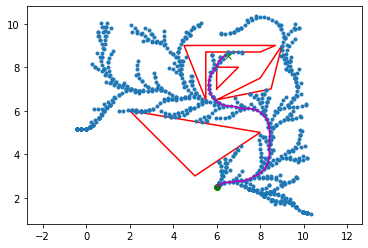

In [10]:
dx = tree[:,0]-goal[0]
dxx = dx**2
dy = tree[:,1]-goal[1]
dyy = dy**2
dsq = dxx+dyy
gn = np.argmin(dsq)

for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot(tree[:,0],tree[:,1],'.')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.axis('equal')
while parents[gn]>=0:
    plt.plot(tree[[gn,parents[gn]],0],tree[[gn,parents[gn]],1],'m-')
    gn = parents[gn]
plt.show()